In [1060]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import chi2_contingency

#### Importing from cleaned data notebook

In [1061]:
data = pd.read_csv('data_clean.csv')

In [1062]:
data.head()

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
3,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
4,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


In [1063]:
data.shape

(18000, 16)

In [1064]:
data["offer_accepted"].value_counts()

No     16977
Yes     1023
Name: offer_accepted, dtype: int64

#### Numerical / categorical columns split

In [1065]:
cat_columns = []
num_columns = []

for i in data.columns:
    if len(data[i].unique()) > 10:
        num_columns.append(i)
    else:
        cat_columns.append(i)

In [1066]:
num = data[num_columns]
num.head()

,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,1160.75,1669.0,877.0,1095.0,1002.0
1,147.25,39.0,106.0,78.0,366.0
2,276.50,367.0,352.0,145.0,242.0
3,1219.00,1578.0,1760.0,1119.0,419.0
4,1211.00,2140.0,1357.0,982.0,365.0


In [1067]:
for i in num.columns:
    print(num[i].describe())

count    18000.000000
mean       940.604208
std        350.072621
min         48.250000
25%        787.937500
50%       1007.000000
75%       1152.562500
max       3366.250000
Name: average_balance, dtype: float64
count    18000.000000
mean       910.266056
std        619.684111
min          0.000000
25%        393.000000
50%        772.000000
75%       1520.250000
max       3450.000000
Name: q1_balance, dtype: float64
count    18000.000000
mean       999.435667
std        457.098763
min          0.000000
25%        664.000000
50%       1032.000000
75%       1342.000000
max       3421.000000
Name: q2_balance, dtype: float64
count    18000.000000
mean      1041.904889
std        553.094705
min          0.000000
25%        633.000000
50%        945.500000
75%       1462.000000
max       3823.000000
Name: q3_balance, dtype: float64
count    18000.000000
mean       810.042889
std        558.642246
min          0.000000
25%        363.750000
50%        703.000000
75%       1211.000000
max  

In [1068]:
cat.head()

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home
0,No,Air Miles,Letter,High,1,No,High,2,1,4,No
1,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes
2,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes
3,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No
4,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes


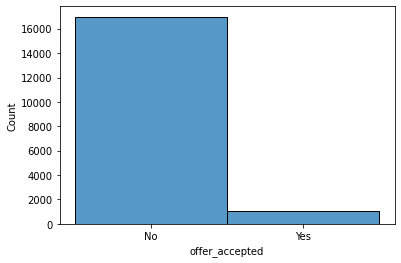

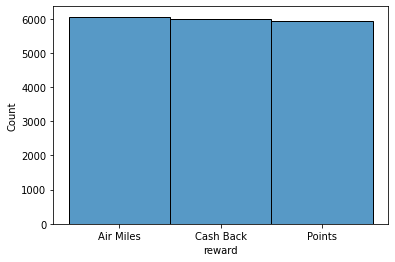

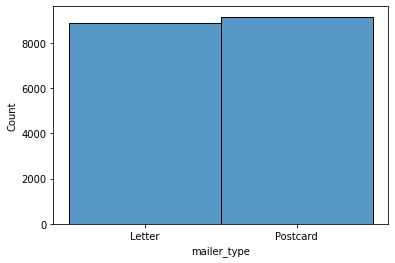

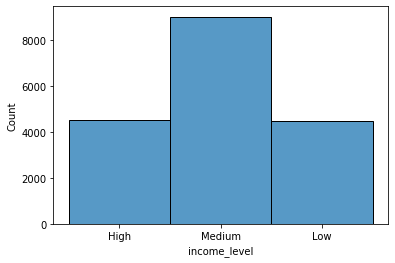

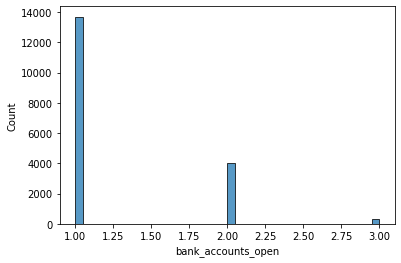

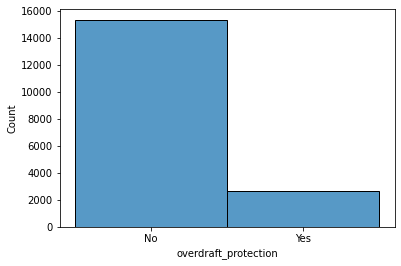

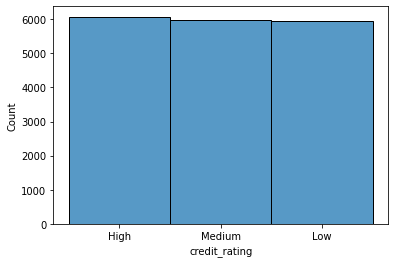

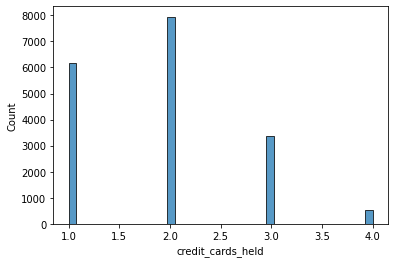

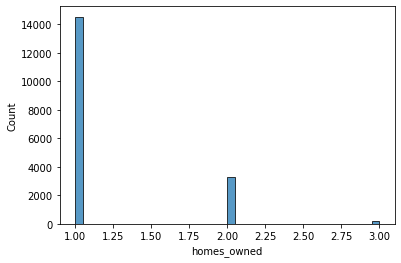

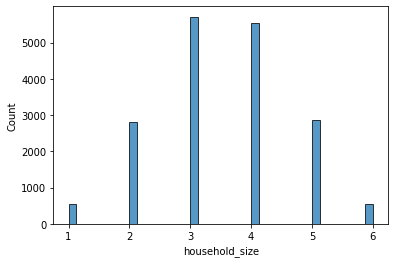

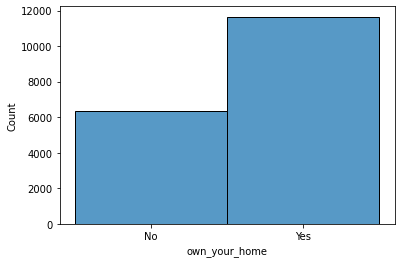

In [1069]:
for i in range(cat.shape[1]):
    sns.histplot(cat[cat.columns[i]], bins=40)
    plt.show()

In [1070]:
#Replacing low frequency values in household_size and clustering them under value=6
data['household_size'] = data['household_size'].apply(lambda x: 6 if x>6 else x)

<AxesSubplot:xlabel='bank_accounts_open', ylabel='count'>

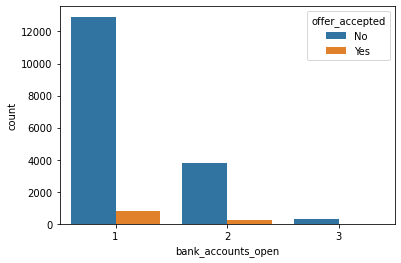

In [1071]:
#checking other columns with multiple values to decide whether to group or keep all categories
sns.countplot(x = 'bank_accounts_open', hue = 'offer_accepted', data = data)

<AxesSubplot:xlabel='credit_cards_held', ylabel='count'>

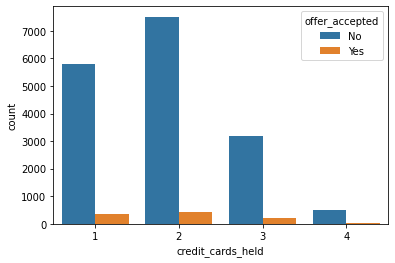

In [1072]:
sns.countplot(x = 'credit_cards_held', hue = 'offer_accepted', data = data)

#### Checking Multicollinearity
<br>
1. Numerical variables

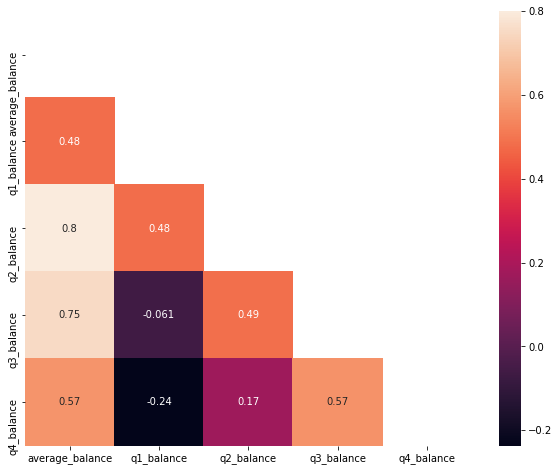

In [1073]:
correlations_matrix = num.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

In [1074]:
vif = {}
numer_vif = num
numer_vif= add_constant(num)

In [1075]:
for i in np.arange(numer_vif.shape[1]):
    column_name = numer_vif.columns[i]
    value = variance_inflation_factor(np.array(numer_vif), i)
    vif[column_name] = value
vif    

{'const': 8.268845743264167,
 'average_balance': 4447.523660455172,
 'q1_balance': 871.3913136229564,
 'q2_balance': 476.80592208638893,
 'q3_balance': 695.2171601202452,
 'q4_balance': 709.0042955328568}

Very correlated so try and extract the useful information from these columns. 
<br>

max_quarter/min_quarter are the quarters with the highest and lowest balances
<br>
max/min are the highest and lowest balances
<br>
range is the difference between max and min balances

In [1076]:
def minmax_func(df):
    max_q = df.idxmax(axis=1)
    min_q = df.idxmin(axis=1)
    max_ = df.max(axis=1)
    min_ = df.min(axis=1)
    range_ = (df.max(axis=1))-(df.min(axis=1))
    
    
    df["max_quarter"] = max_q
    df["min_quarter"] = min_q
    df["range"] = range_
    df["max"] = max_
    df["min"] = min_
    
    return df
   
num = minmax_func(num)

In [1077]:
#renaming the columns with the quarters
num['max_quarter'] = list(map(lambda x: x[:2],num['max_quarter']))
num['min_quarter'] = list(map(lambda x: x[:2],num['min_quarter']))

In [1078]:
num.head()

,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,max_quarter,min_quarter,range,max,min
0,1160.75,1669.0,877.0,1095.0,1002.0,q1,q2,792.0,1669.0,877.0
1,147.25,39.0,106.0,78.0,366.0,q4,q1,327.0,366.0,39.0
2,276.50,367.0,352.0,145.0,242.0,q1,q3,222.0,367.0,145.0
3,1219.00,1578.0,1760.0,1119.0,419.0,q2,q4,1341.0,1760.0,419.0
4,1211.00,2140.0,1357.0,982.0,365.0,q1,q4,1775.0,2140.0,365.0


In [1079]:
#add new min_quarter/max_quarter columns to the categorical data and drop from numerical
cat = data[cat_columns]
cat["max_quarter"] = num["max_quarter"]
cat["min_quarter"] = num["min_quarter"]
num = num.drop(["max_quarter", "min_quarter"], axis = 1)

In [1080]:
num.head()

,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,range,max,min
0,1160.75,1669.0,877.0,1095.0,1002.0,792.0,1669.0,877.0
1,147.25,39.0,106.0,78.0,366.0,327.0,366.0,39.0
2,276.50,367.0,352.0,145.0,242.0,222.0,367.0,145.0
3,1219.00,1578.0,1760.0,1119.0,419.0,1341.0,1760.0,419.0
4,1211.00,2140.0,1357.0,982.0,365.0,1775.0,2140.0,365.0


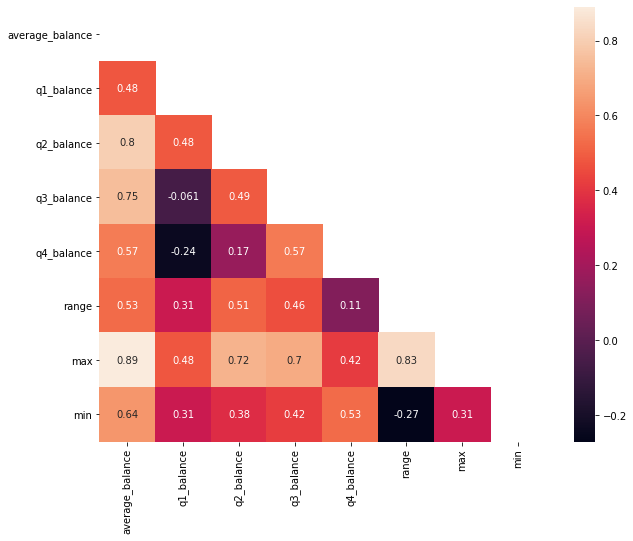

In [1081]:
#check new numerical columns (min, max, range) against all numerical columns
correlations_matrix = num.corr()
mask = np.zeros_like(correlations_matrix) 
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

In [1082]:
# "max" correlates strongly with avg balance and range so remove
# data = data.drop(["max"], axis = 1)

2. Categorical variables

In [1083]:
cat.head()

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,max_quarter,min_quarter
0,No,Air Miles,Letter,High,1,No,High,2,1,4,No,q1,q2
1,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,q4,q1
2,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,q1,q3
3,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,q2,q4
4,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,q1,q4


In [1084]:
#create new dataframe dropping the target variable
cat2 = cat.drop(['offer_accepted'], axis = 1)
cat2.shape

(18000, 12)

In [1085]:
cat2.head()

,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,max_quarter,min_quarter
0,Air Miles,Letter,High,1,No,High,2,1,4,No,q1,q2
1,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,q4,q1
2,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,q1,q3
3,Air Miles,Letter,Medium,2,No,High,1,1,4,No,q2,q4
4,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,q1,q4


In [1086]:
#check chi-squared value of all pairs of categorical variables

lst1 = []
lst2 = []
lst3 = []


for i,n in enumerate(cat2.columns):
    x = 1
    while x < len(cat2.columns)-i:
        crosstab = pd.crosstab(cat2[n],cat2[cat2.columns[i+x]])
        lst1.append(n)
        lst2.append(cat2.columns[i+x])
        lst3.append(chi2_contingency(crosstab, correction=False)[1])
        x += 1

df = pd.concat([pd.DataFrame(lst1),pd.DataFrame(lst2),pd.DataFrame(lst3)], axis =1)

In [1087]:
#check which pairs of columns have a p value of less than 0.05
df[df.iloc[:,2]<0.05] 

,0,0,0
19,mailer_type,max_quarter,0.007761
49,credit_rating,max_quarter,0.008498
50,credit_rating,min_quarter,0.013072
54,credit_cards_held,max_quarter,0.009283
65,max_quarter,min_quarter,0.000000


In [1088]:
#drop "max_quarter" and "min_quarter" from main cat dataset as they are correlated with each other and other categorical variables

cat = cat.drop(["max_quarter", "min_quarter"], axis=1)
cat.head()

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home
0,No,Air Miles,Letter,High,1,No,High,2,1,4,No
1,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes
2,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes
3,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No
4,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes


In [1089]:
#combine numerical and categorical columns after multicollinearity checks

data = pd.concat([cat, num], axis =1)

In [1090]:
data.head()

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,range,max,min
0,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0,792.0,1669.0,877.0
1,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0,327.0,366.0,39.0
2,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0,222.0,367.0,145.0
3,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0,1341.0,1760.0,419.0
4,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0,1775.0,2140.0,365.0


3.Numerical - Categorical

In [1091]:
#Check average_balance against categorical variables(exclude target)

cat2 = cat.drop(['offer_accepted'], axis = 1)

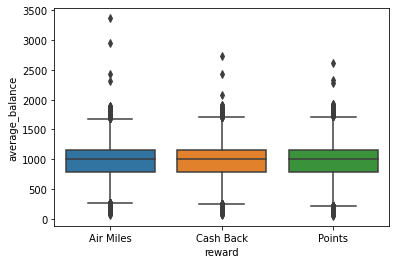

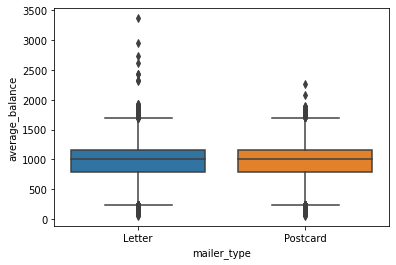

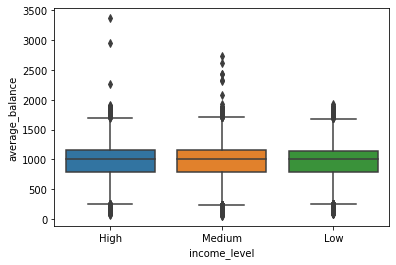

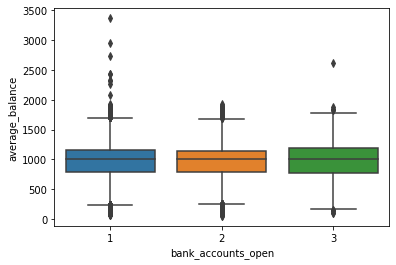

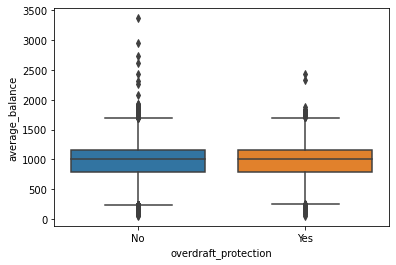

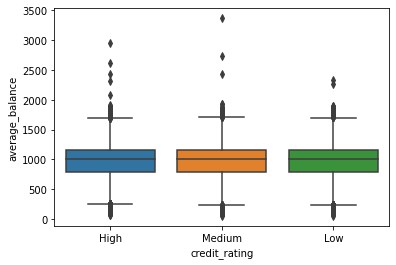

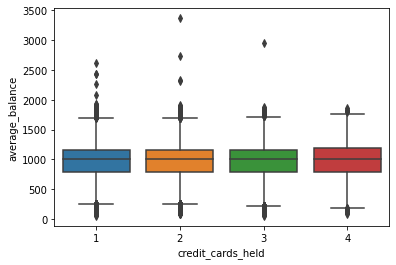

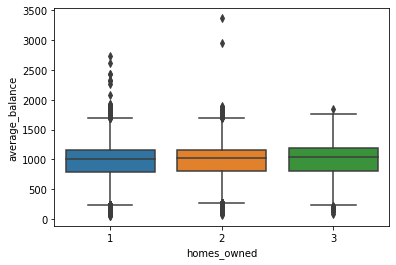

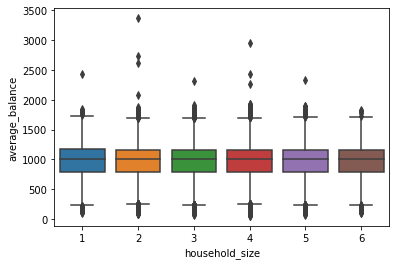

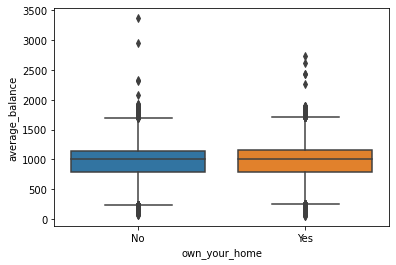

In [1092]:
for i in cat2:
    sns.boxplot(x=i, y="average_balance", data = data)
    plt.show()

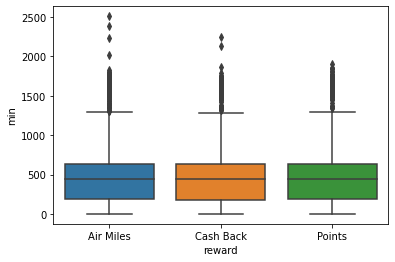

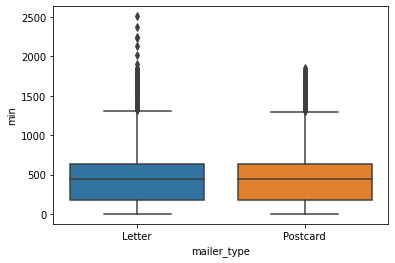

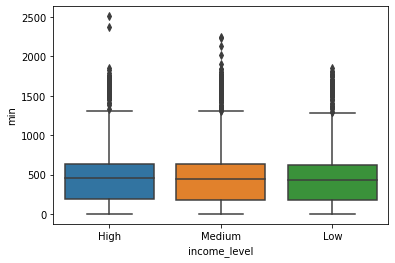

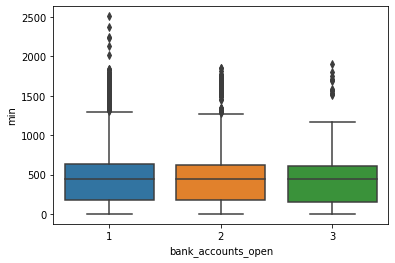

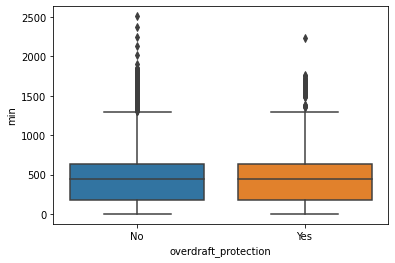

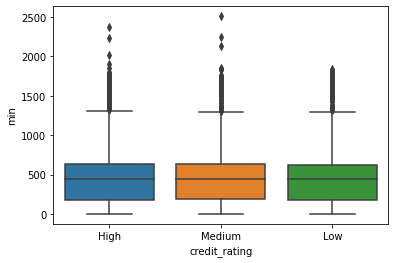

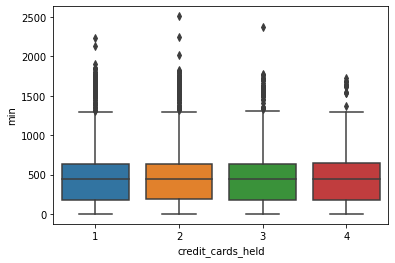

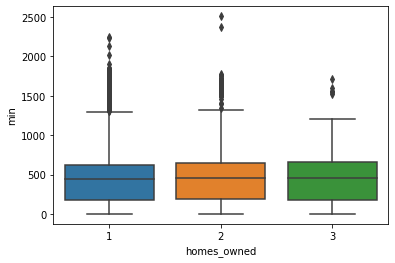

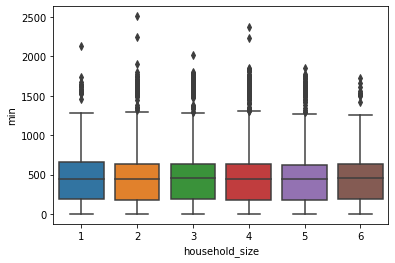

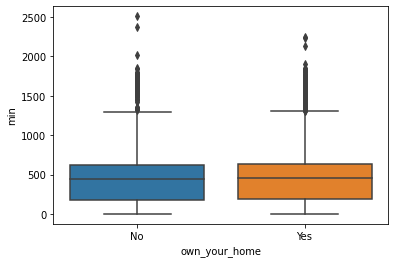

In [1093]:
#check min against categorical variables
for i in cat2:
    sns.boxplot(x=i, y="min", data = data)
    plt.show()

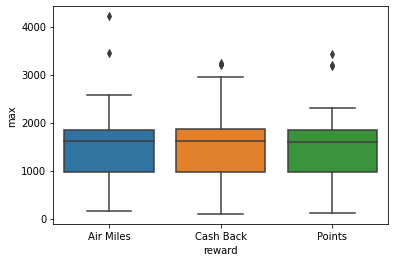

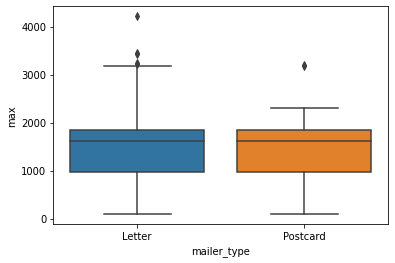

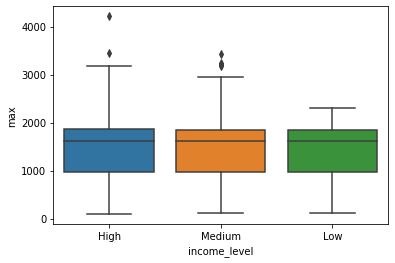

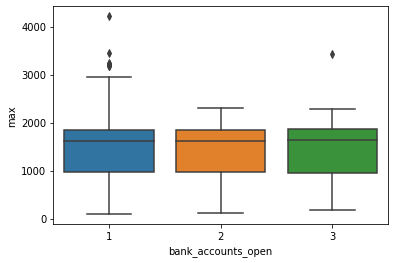

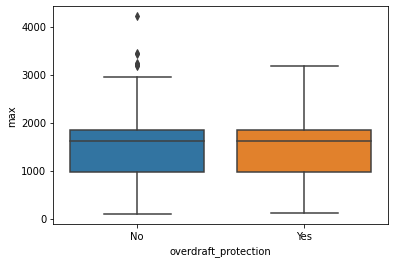

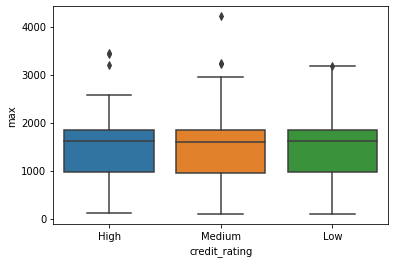

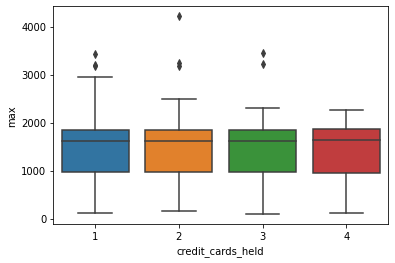

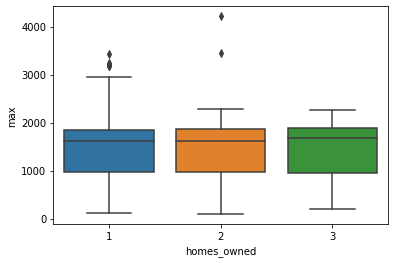

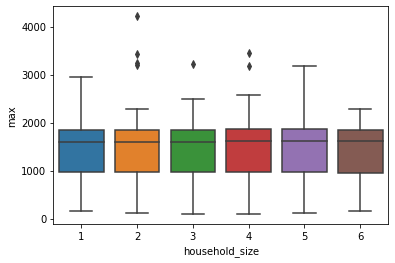

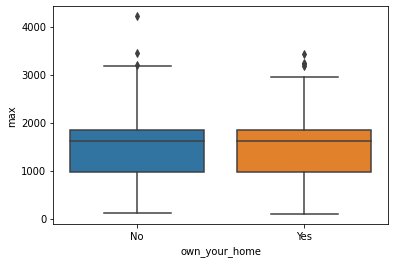

In [1094]:
#check max against categorical variables
for i in cat2:
    sns.boxplot(x=i, y="max", data = data)
    plt.show()

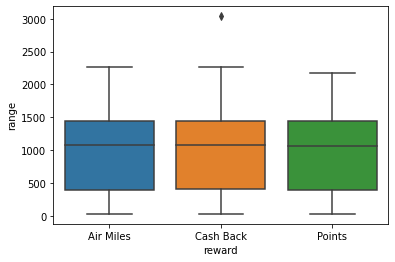

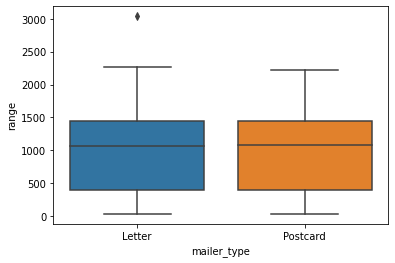

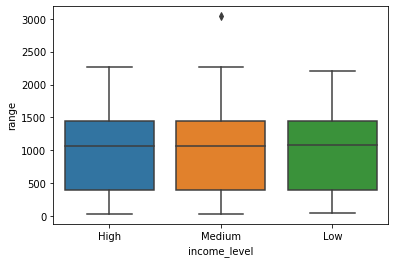

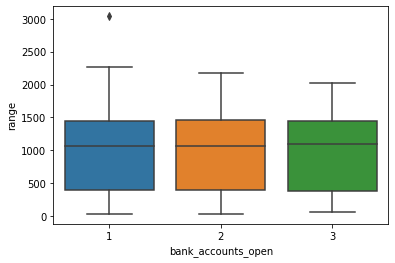

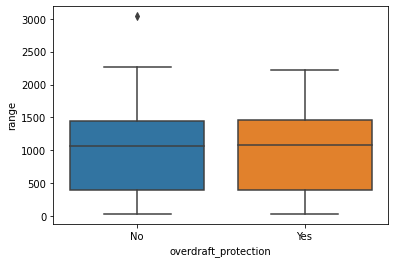

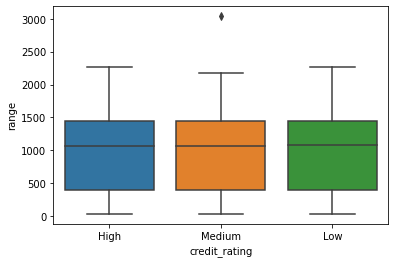

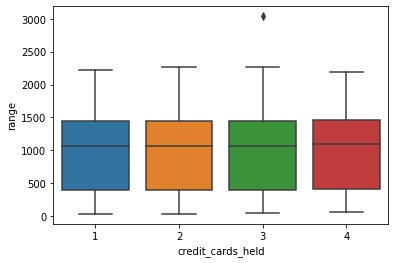

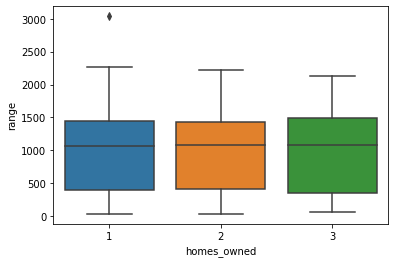

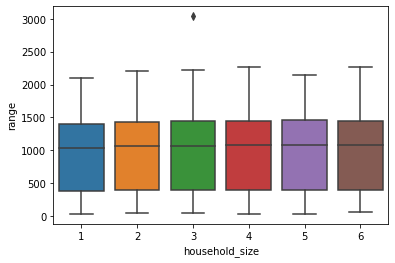

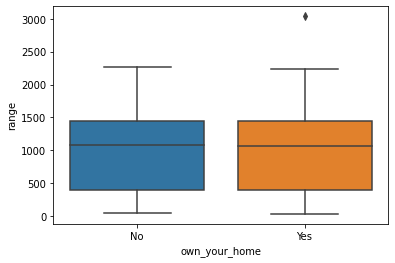

In [1095]:
#check range against categorical variables
for i in cat2:
    sns.boxplot(x=i, y="range", data = data)
    plt.show()

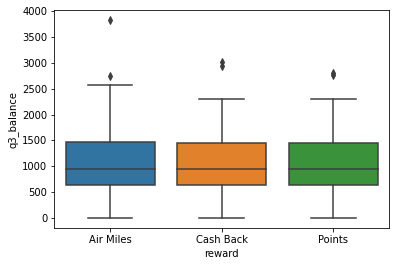

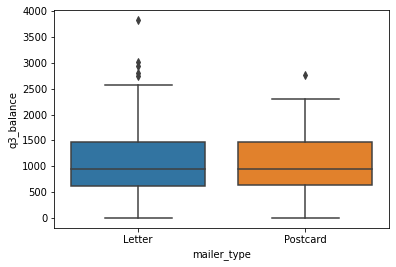

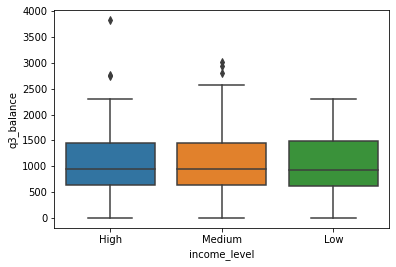

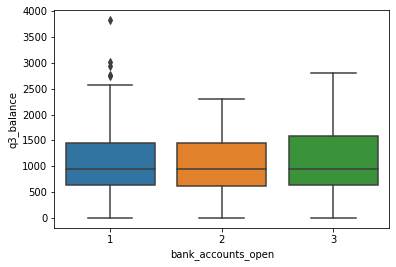

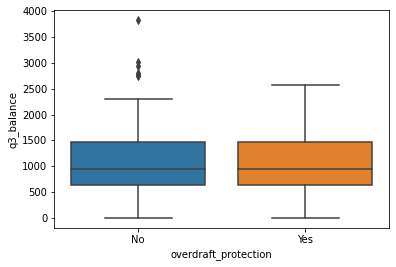

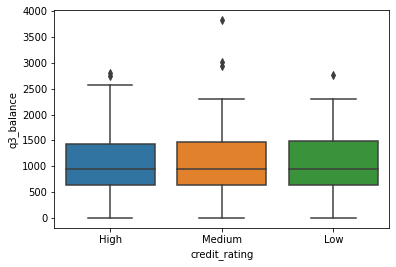

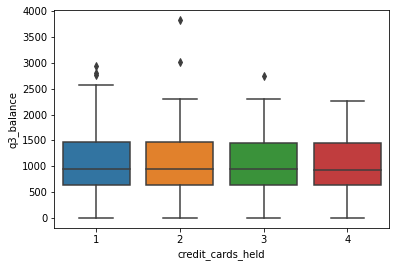

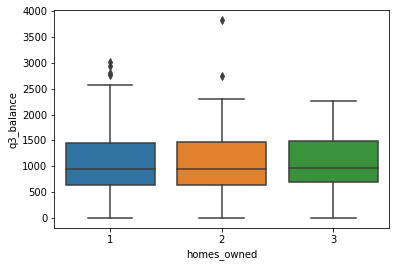

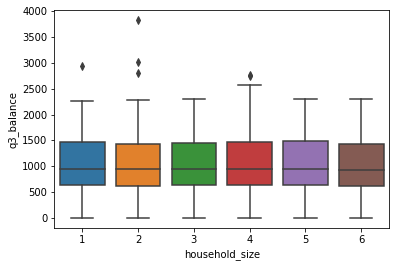

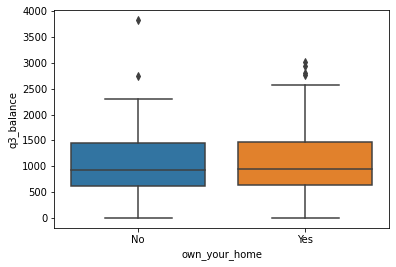

In [1096]:
#check q3 against categorical variables
for i in cat2:
    sns.boxplot(x=i, y="q3_balance", data = data)
    plt.show()

Result: no multicollinearity between categorical and numerical variables was found

#### Correlation between categrical variables and target

In [1097]:
#check chi-squared values of all pairs of categorical variables and target

lst1 = []
lst2 = []
lst3 = []


for i,n in enumerate(cat.columns):
    x = 1
    while x < len(cat.columns)-i:
        crosstab = pd.crosstab(cat[n],cat[cat.columns[i+x]])
        lst1.append(n)
        lst2.append(cat.columns[i+x])
        lst3.append(chi2_contingency(crosstab, correction=False)[1])
        x += 1

df = pd.concat([pd.DataFrame(lst1),pd.DataFrame(lst2),pd.DataFrame(lst3)], axis =1)

In [1098]:
df[df.iloc[:,0]=='offer_accepted'] 

,0,0,0
0,offer_accepted,reward,7.103827e-23
1,offer_accepted,mailer_type,4.191441e-39
2,offer_accepted,income_level,1.463496e-25
3,offer_accepted,bank_accounts_open,5.787149e-01
4,offer_accepted,overdraft_protection,7.040047e-01
5,offer_accepted,credit_rating,5.967269e-97
6,offer_accepted,credit_cards_held,7.191405e-01
7,offer_accepted,homes_owned,8.816359e-01
8,offer_accepted,household_size,9.423216e-02
9,offer_accepted,own_your_home,9.673462e-01


In [1099]:
# Result: p value is high (>0,5) for the following cat variables: bank_accounts_open, overdraft_protection, credit_cards_held, homes_owned, own_your_home.
# So drop then as there ar not related wiht he target

# data = data.drop(["bank_accounts_open", "overdraft_protection", "credit_cards_held", "homes_owned", "own_your_home"], axis = 1)

Removing Outliers

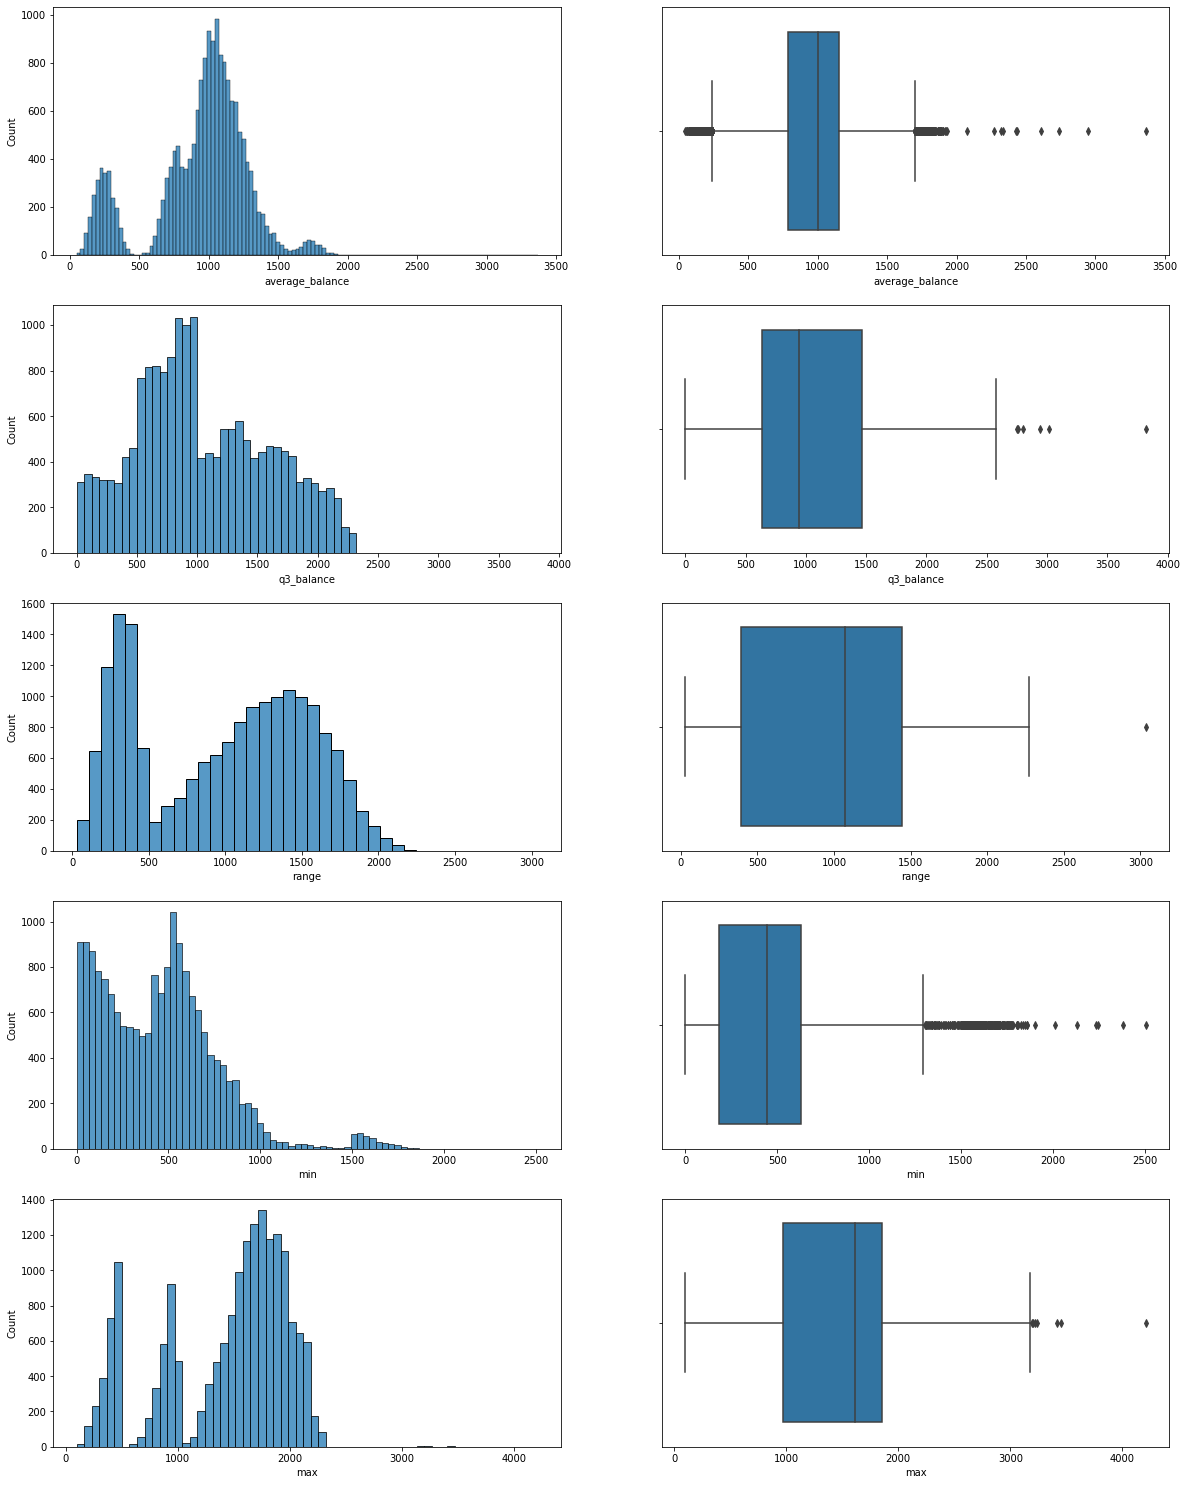

In [1100]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5,2,figsize = (20, 20)) 
plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 

sns.histplot(data["average_balance"], ax=ax1)
sns.boxplot(data['average_balance'], ax=ax2)
sns.histplot(data['q3_balance'], ax=ax3)
sns.boxplot(data['q3_balance'], ax=ax4)
sns.histplot(data['range'], ax=ax5)
sns.boxplot(data['range'], ax=ax6)
sns.histplot(data['min'], ax=ax7)
sns.boxplot(data['min'], ax=ax8)
sns.histplot(data['max'], ax=ax9)
sns.boxplot(data['max'], ax=ax10)

plt.show()

In [1101]:
#remove outliers from average balance
iqr = np.percentile(data['average_balance'],75) - np.percentile(data['average_balance'],25)
upper_limit = np.percentile(data['average_balance'],75) + 2*iqr
lower_limit = np.percentile(data['average_balance'],25) - 2*iqr
data =data[(data['average_balance']>lower_limit) & (data['average_balance']<upper_limit)]

<AxesSubplot:>

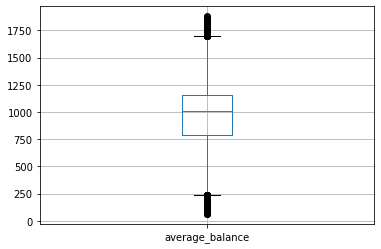

In [1102]:
data.boxplot(column=['average_balance'])

In [1103]:
#remove outliers from q3 balance
iqr = np.percentile(data['q3_balance'],75) - np.percentile(data['q3_balance'],25)
upper_limit = np.percentile(data['q3_balance'],75) + 1.5*iqr
lower_limit = np.percentile(data['q3_balance'],25) - 1.5*iqr
data =data[(data['q3_balance']>lower_limit) & (data['q3_balance']<upper_limit)]

<AxesSubplot:>

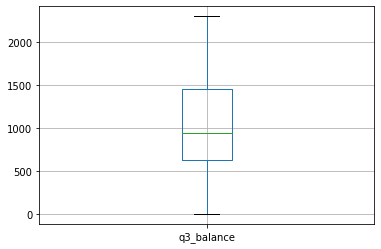

In [1104]:
data.boxplot(column=['q3_balance'])

In [1105]:
#remove outliers from range
iqr = np.percentile(data['range'],75) - np.percentile(data['range'],25)
upper_limit = np.percentile(data['range'],75) + 1.5*iqr
lower_limit = np.percentile(data['range'],25) - 1.5*iqr
data =data[(data['range']>lower_limit) & (data['range']<upper_limit)]

<AxesSubplot:>

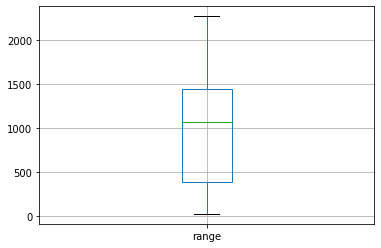

In [1106]:
data.boxplot(column=['range'])

In [1107]:
#remove outliers from min
iqr = np.percentile(data['min'],75) - np.percentile(data['min'],25)
upper_limit = np.percentile(data['min'],75) + 2*iqr
lower_limit = np.percentile(data['min'],25) - 2*iqr
data =data[(data['min']>lower_limit) & (data['min']<upper_limit)]

<AxesSubplot:>

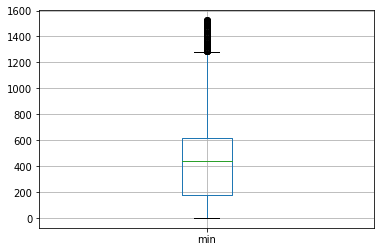

In [1108]:
data.boxplot(column=['min'])

In [1109]:
#remove outliers from max
iqr = np.percentile(data['max'],75) - np.percentile(data['max'],25)
upper_limit = np.percentile(data['max'],75) + 2*iqr
lower_limit = np.percentile(data['max'],25) - 2*iqr
data =data[(data['max']>lower_limit) & (data['max']<upper_limit)]

<AxesSubplot:>

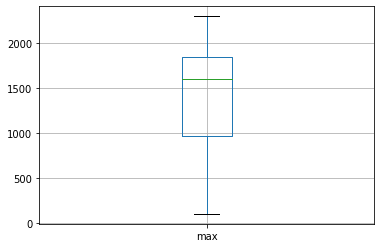

In [1110]:
data.boxplot(column=['max'])

In [1111]:
data.shape

(17711, 19)

In [1112]:
data["offer_accepted"].value_counts()

No     16699
Yes     1012
Name: offer_accepted, dtype: int64

Splitting numericals and categoricals again

In [1113]:
cat_columns = []
num_columns = []

for i in data.columns:
    if len(data[i].unique()) > 10:
        num_columns.append(i)
    else:
        cat_columns.append(i)   

num = data[num_columns]
cat = data[cat_columns]

Numericals - applying transformations, tested LOG transformation, BoxCox and Square Root

In [1114]:
def log_transform_clean(x):
    if x>0:
        return np.log(x)
    else:
        return 0  # in the code to be used with dataframe, we will use np.NaN here 

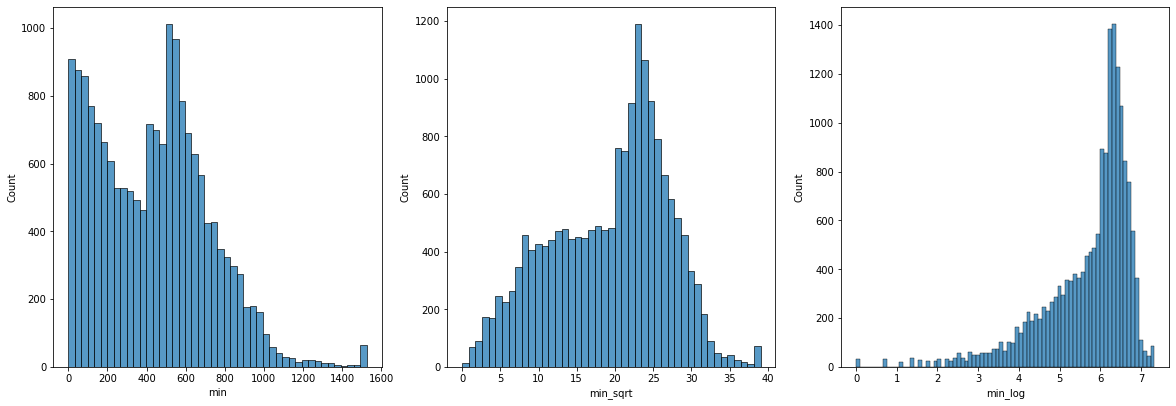

In [1115]:
#checking transformations of min

num['min_sqrt'] = num['min']**(1/2)
num["min_log"] = list(map(log_transform_clean, num["min"]))
#min_bc, lmbda = stats.boxcox(data["min"]) -can't do boxcox because some values = 0

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,5)) 
plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 
sns.histplot(num['min'], ax=ax1)
sns.histplot(num['min_sqrt'], ax=ax2)
sns.histplot(num["min_log"], ax=ax3)
#sns.displot(min_bc, ax=ax4)
plt.show()

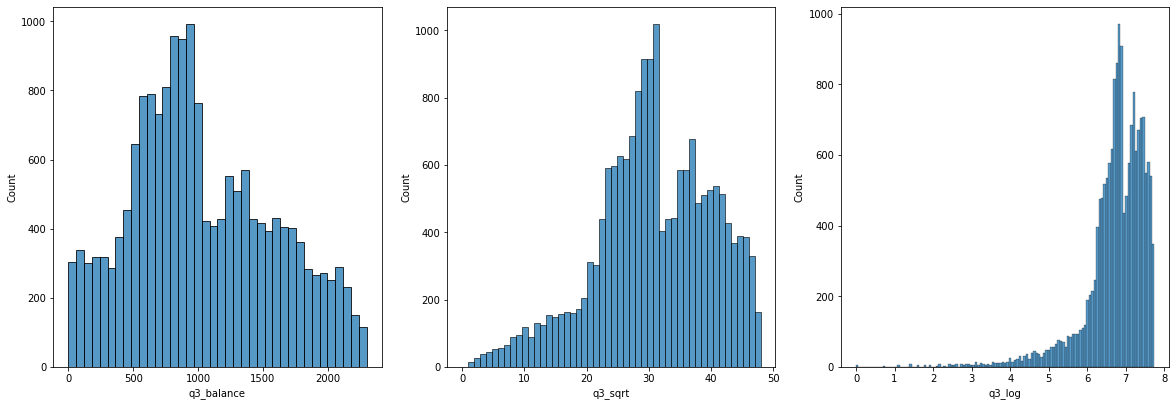

In [1116]:
#checking transformations of q3 balance

num['q3_sqrt'] = num['q3_balance']**(1/2)
num["q3_log"] = list(map(log_transform_clean, num["q3_balance"]))
#q3_bc, lmbda = stats.boxcox(data["q3_balance"]) #can't do boxcox because some values < 0

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,5)) 
plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 
sns.histplot(num['q3_balance'], ax=ax1)
sns.histplot(num['q3_sqrt'], ax=ax2)
sns.histplot(num["q3_log"], ax=ax3)
#sns.displot(q3_bc, ax=ax4)

plt.show()

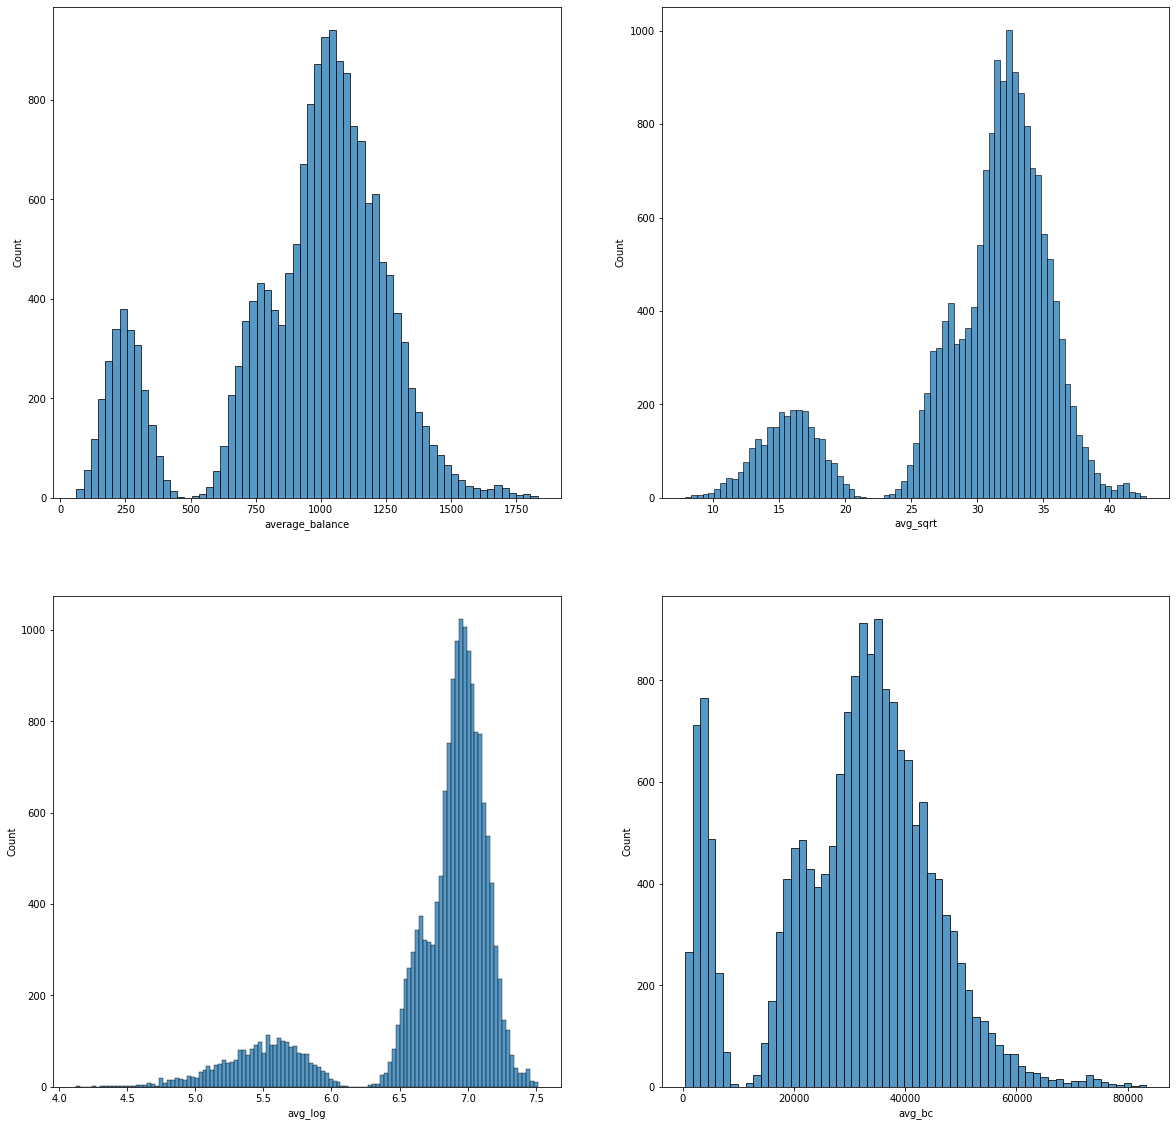

In [1117]:
#checking transformations of average balance

num['avg_sqrt'] = num['average_balance']**(1/2)
num["avg_log"] = list(map(log_transform_clean, num["average_balance"]))
avg_bc, lmbda = stats.boxcox(num["average_balance"]) 
num["avg_bc"]= avg_bc
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (20,15)) 
plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 
sns.histplot(num['average_balance'], ax=ax1)
sns.histplot(num['avg_sqrt'], ax=ax2)
sns.histplot(num["avg_log"], ax=ax3)
sns.histplot(num["avg_bc"], ax=ax4)

plt.show()

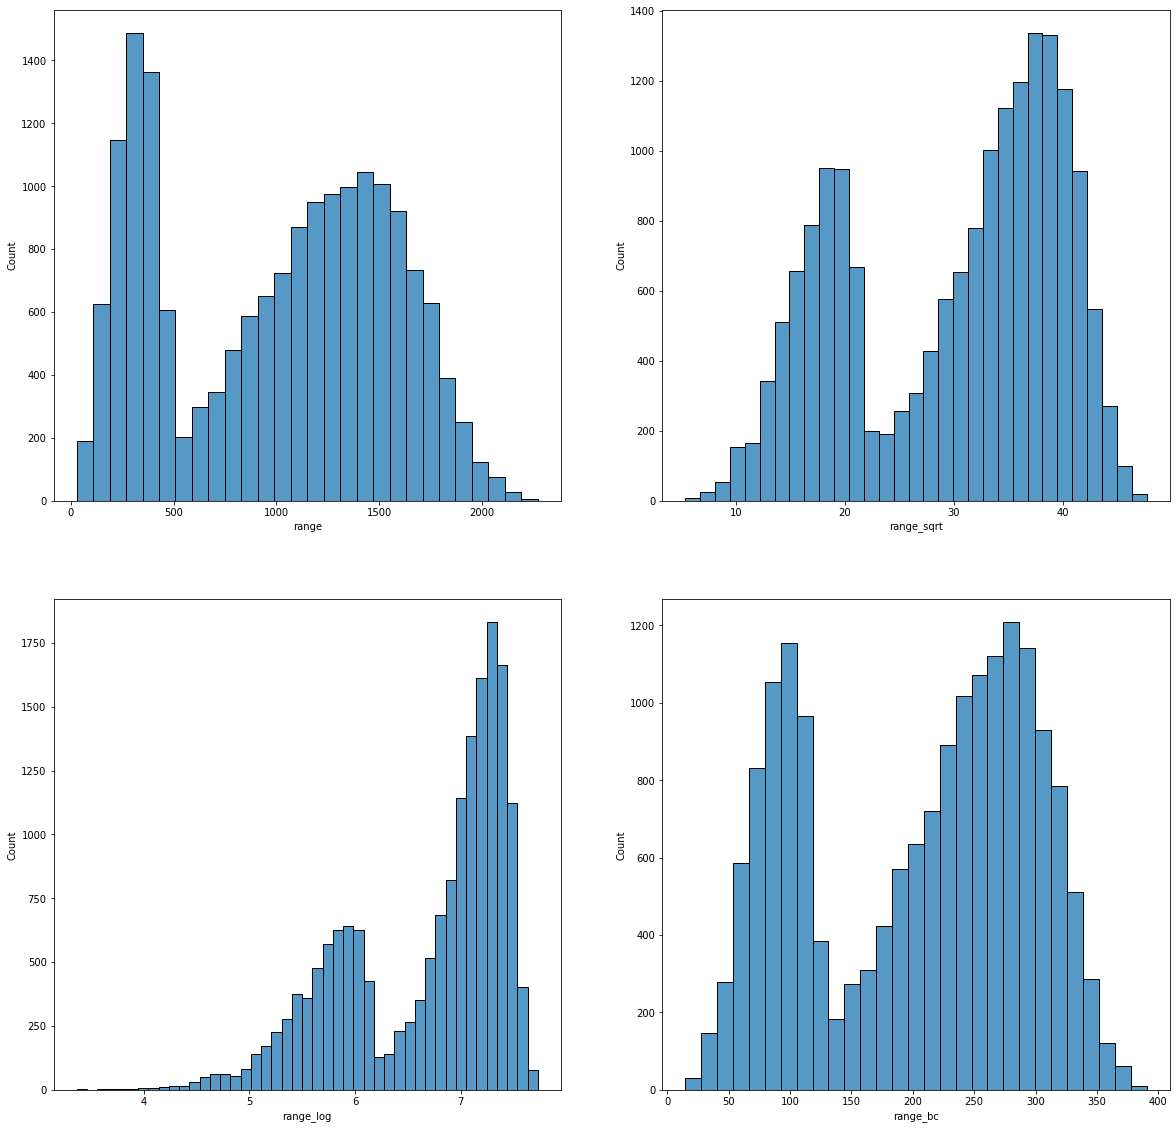

In [1118]:
#checking transformations of range


num['range_sqrt'] = num['range']**(1/2)
num["range_log"] = list(map(log_transform_clean, num["range"]))
rng_bc, lmbda = stats.boxcox(num["range"]) 
num["range_bc"] = rng_bc

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (20,15)) 
plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 
sns.histplot(num['range'], ax=ax1)
sns.histplot(num['range_sqrt'], ax=ax2)
sns.histplot(num["range_log"], ax=ax3)
sns.histplot(num["range_bc"], ax=ax4)
plt.show()

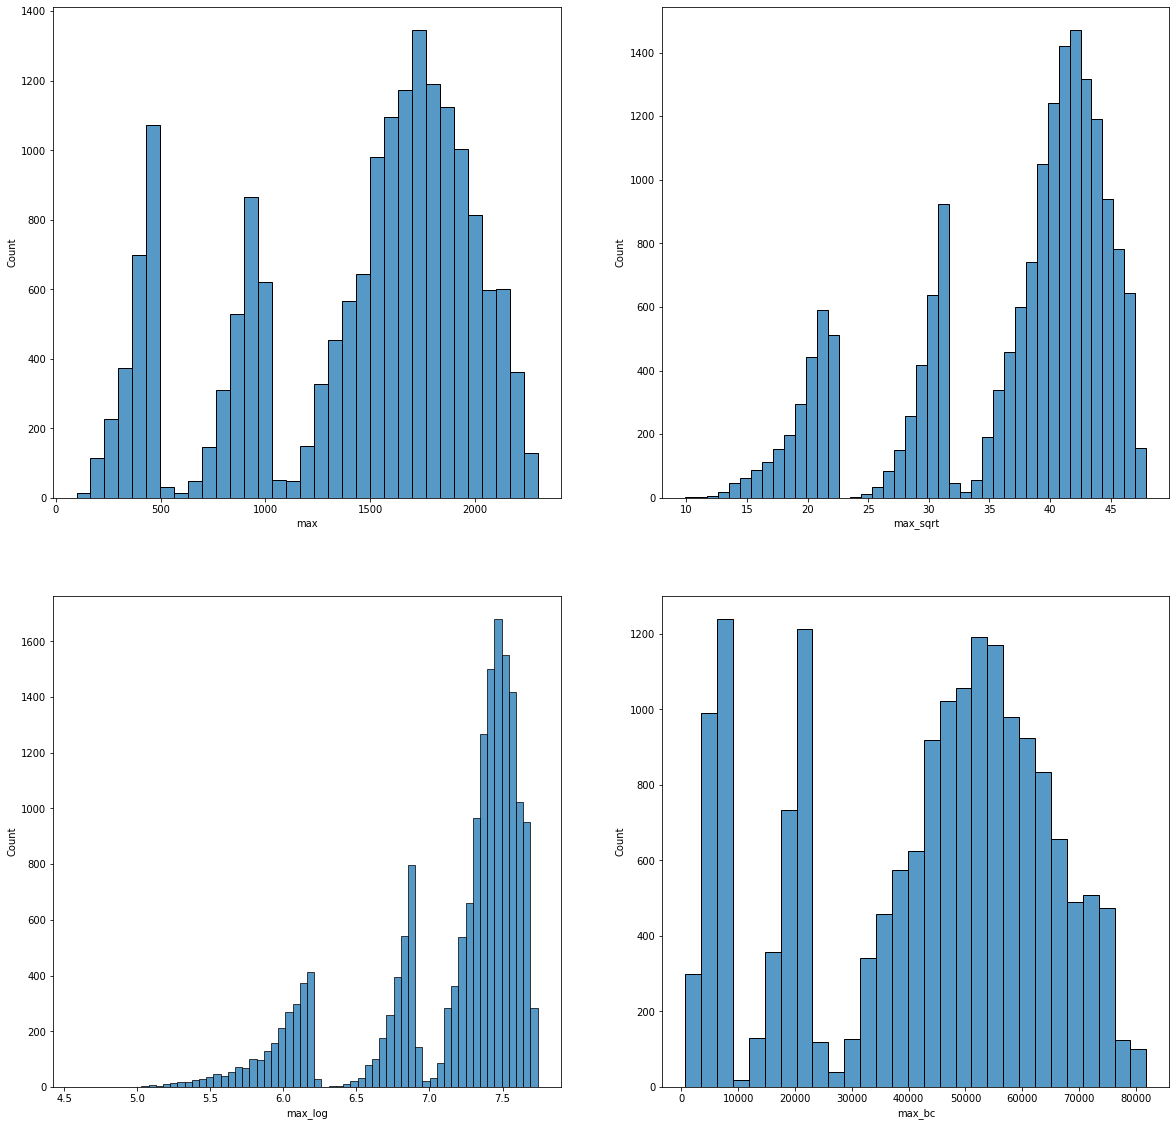

In [1119]:
#checking transformations of max

#calculate transformations
num['max_sqrt'] = num['max']**(1/2)
num["max_log"] = list(map(log_transform_clean, num["max"]))
max_bc, lmbda = stats.boxcox(num["max"]) 
num["max_bc"] = max_bc

#plot transformations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (20,15)) 
plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 
sns.histplot(num['max'], ax=ax1)
sns.histplot(num['max_sqrt'], ax=ax2)
sns.histplot(num["max_log"], ax=ax3)
sns.histplot(num["max_bc"], ax=ax4)

plt.show()

In [1120]:
num.head()

,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,range,max,min,min_sqrt,min_log,q3_sqrt,q3_log,avg_sqrt,avg_log,avg_bc,range_sqrt,range_log,range_bc,max_sqrt,max_log,max_bc
0,1160.75,1669.0,877.0,1095.0,1002.0,792.0,1669.0,877.0,29.614186,6.776507,33.090784,6.998510,34.069781,7.056822,40766.039813,28.142495,6.674561,179.791934,40.853396,7.419980,50381.652405
1,147.25,39.0,106.0,78.0,366.0,327.0,366.0,39.0,6.244998,3.663562,8.831761,4.356709,12.134661,4.992132,1599.879583,18.083141,5.789960,93.415532,19.131126,5.902633,5055.028925
2,276.50,367.0,352.0,145.0,242.0,222.0,367.0,145.0,12.041595,4.976734,12.041595,4.976734,16.628289,5.622211,4298.105300,14.899664,5.402677,70.010412,19.157244,5.905362,5075.974037
3,1219.00,1578.0,1760.0,1119.0,419.0,1341.0,1760.0,419.0,20.469489,6.037871,33.451457,7.020191,34.914181,7.105786,44019.351846,36.619667,7.201171,265.036036,41.952354,7.473069,54601.986795
4,1211.00,2140.0,1357.0,982.0,365.0,1775.0,2140.0,365.0,19.104973,5.899897,31.336879,6.889591,34.799425,7.099202,43567.199019,42.130749,7.481556,325.755988,46.260134,7.668561,73426.753062


In [1121]:
#choose which transformations to use
num = num[["min_sqrt", "max_sqrt", "q3_sqrt", "avg_bc","range_bc"]] 

In [1122]:
num.shape

(17711, 5)

Categorical Encoding

In [1123]:
cat.head()

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home
0,No,Air Miles,Letter,High,1,No,High,2,1,4,No
1,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes
2,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes
3,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No
4,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes


In [1124]:
cat.shape

(17711, 11)

In [1125]:
#ordinal encoding
#cat["credit_rating"]=cat["credit_rating"].apply(lambda x : 3 if x == "High" else(2 if x == "Medium" else 1))
#cat["income_level"]=cat["income_level"].apply(lambda x : 3 if x == "High" else(2 if x == "Medium" else 1))
#cat["overdraft_protection"] = cat["overdraft_protection"].apply(lambda x : 1 if x == "Yes" else 0)
#ord_cat = cat.select_dtypes(exclude = object)

In [1126]:
cat.head()

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home
0,No,Air Miles,Letter,High,1,No,High,2,1,4,No
1,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes
2,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes
3,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No
4,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes


Encoding Nominal Categoricals - OneHot Encoder

In [1127]:
from sklearn.preprocessing import OneHotEncoder

In [1128]:
y = cat["offer_accepted"]
cat = cat.drop(["offer_accepted"], axis = 1)

In [1129]:
enc = OneHotEncoder(handle_unknown='error', drop='first')
enc_cat = pd.DataFrame(enc.fit_transform(cat).toarray())


concat with Scaled Numerical

In [1130]:
data_enc = pd.DataFrame(np.concatenate([enc_cat,num], axis =1))

In [1131]:
data_enc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,29.614186,40.853396,33.090784,40766.039813,179.791934
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,6.244998,19.131126,8.831761,1599.879583,93.415532
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,12.041595,19.157244,12.041595,4298.105300,70.010412
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,20.469489,41.952354,33.451457,44019.351846,265.036036
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,19.104973,46.260134,31.336879,43567.199019,325.755988


In [1132]:
data_enc.shape

(17711, 26)

In [1133]:
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler().fit(data_enc)
x_standardized = transformer.transform(data_enc)
print(x_standardized.shape)

(17711, 26)


In [1134]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(data_enc)
x_normalized = transformer.transform(data_enc)
print(x_normalized.shape)

(17711, 26)


In [1135]:
X = x_standardized

Concatenate X with y and export to csv

In [1136]:
data_preprocessed = pd.DataFrame(np.concatenate([X,pd.DataFrame(y)],axis=1))

In [1137]:
data_preprocessed.to_csv('data_preprocessed.csv', index=False)